In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy import signal
from scipy.io.wavfile import write
from scipy.io.wavfile import read
import IPython

# Carrier Setup

200 samples!


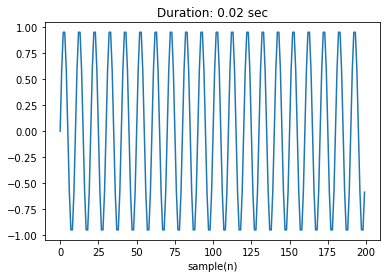

In [78]:
#pulse duration = samples/Fs, duration*Fs = samples
duration = .02
Fs = 10000
f = 1000
sample = round(duration*Fs)
print(str(sample) + ' samples!')

x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)
plt.plot(x[:500], y[:500])
plt.xlabel('sample(n)')
plt.title('Duration: ' + str(sample/Fs) + ' sec')
plt.show()

In [3]:
write('OOK.wav', Fs, y.astype(np.float32))
IPython.display.Audio('OOK.wav')

# Transmit/Receive Development

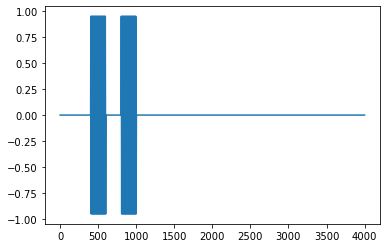

In [4]:
#put symbols together, transmit (1 0 1)
out = np.zeros(20*sample)
out[2*sample:3*sample] = y
out[4*sample:5*sample] = y
plt.plot(out)
plt.show()
write('OOKseq.wav', Fs, out.astype(np.float32))

In [5]:
write('OOKseq.wav', Fs, out.astype(np.float32))
IPython.display.Audio('OOKseq.wav')

Note that each transmission block (audible 1 or 0) has a duration of .02 sec (for demonstration) or 200 samples. We are going to find the first pulse by traversing through the time signal and comparing the current sample with 100 samples ago. Once we find the start point, we will add half the length of pulse to the start point in order to get to the center of the first pulse (our reference point). Finally, we can detect 1 or 0 by advancing 200 samples from the reference point.

In [6]:
#load the received signal
file = 'OOKseq'
samplerate, x = read(file+'.wav')

In [7]:
#find starting point of received signal
thresh = .5 #detection threshold
sigStart = 0
step = int(sample/2) #number of samples to delay by for finding the first pulse
for i in range(step, len(x)):
    currSample = x[i]
    pastSample = x[i-step]
    if np.abs(currSample-pastSample) > thresh:
        sigStart = i + step
        print('reference point: ' + str(sigStart) + ' samples')
        break
        
#find the indecies where we want to sample the received signal
sampleIndex = []
for i in range(sigStart, len(x), sample):
    sampleIndex.append(i)
    
#extract the sequence of 1's and 0's
dataIndex = []
for i in range(0, len(sampleIndex)):
    index = sampleIndex[i]
    if index > len(x):
        break
    if np.abs(x[index]) > thresh:
        dataIndex.append(1)
    else:
        dataIndex.append(0)

reference point: 501 samples


[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


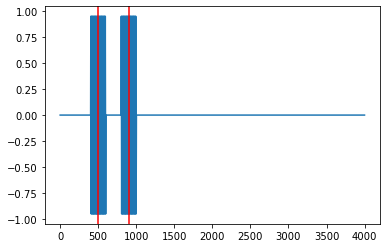

In [8]:
#display the results
plt.plot(x)
for i in range(len(dataIndex)):
    if dataIndex[i] == 1 or dataIndex == 0:
        plt.axvline(sampleIndex[i], color = 'red')
print(dataIndex)

# Transmit/Receive Functions

In [9]:
#bits: array containing sequence of bits to be transmitted
#pulse: audio pulse being transmitted
#returns audio signal for transmission

def tx(bits, pulse):
    txSeq = np.zeros(len(bits)*sample)
    for i in range(len(bits)):
        if bits[i] == 1:
            txSeq[i*sample:(i+1)*sample] = pulse
    return txSeq

In [88]:
#signal: received signal to be decoded
#numSample: number of samples in pulse
#thresh: minimum amplitude for pulse detection
#returns sequence of bits for decoding

def rx(x, numSample, thresh = .5):
    sigStart = 0
    step = int(numSample/2)
    for i in range(step, len(x)):
        currSample = x[i]
        pastSample = x[i-step]
        if np.abs(currSample-pastSample) > thresh:
            sigStart = i + step
            break
    print('sigStart: ' + str(sigStart))
    sampleIndex = []
    for i in range(sigStart, len(x), numSample):
        sampleIndex.append(i)
    dataIndex = []
    zeroCounter = 0
    for i in range(0, len(sampleIndex)):
        index = sampleIndex[i]
        if index > len(x):
            break
        if np.abs(x[index]) > thresh:
            dataIndex.append(1)
            zeroCounter = 0
        else:
            dataIndex.append(0)
            zeroCounter += 1
        if zeroCounter == 8:
            break
    return dataIndex

# Transmit/Receive Demo

sigStart: 301
transmitted: [1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0]
received:    [1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0]


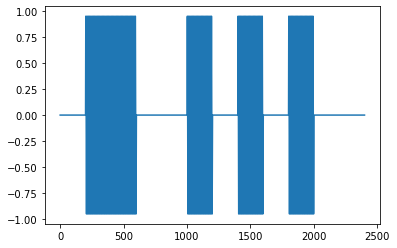

In [89]:
#note: there should be some zero-padding before the first pulse
#this will be handled when an audio signal is recorded in audacity
txBits = [0,1,1,0,0,1,0,1,0,1,0,0]
out = tx(txBits, y)
rxBits = rx(out, sample)
print('transmitted: ' + str(txBits[1:]))
print('received:    ' + str(rxBits))
plt.plot(out)
plt.show()

# Encoding Longer Messages

The idea here will be to convert a string to integer and then convert the integer to binary. We can then transmit the binary, receive it, and convert it back to a string for reading!

[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 

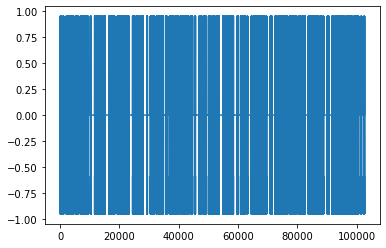

In [143]:
txData = 'Hello, my name is Alexander, this is an OOK prototyping project!'
txData = ''.join(format(ord(i), '08b') for i in txData)
txData = [int(d) for d in str(txData)]
txData.insert(0,1) #this is inserted so that we can synchronize the clock for receiving
print(txData)
out = tx(txData,y)
plt.plot(out)
plt.show()

In [144]:
write('OOKseq.wav', Fs, out.astype(np.float32))
IPython.display.Audio('OOKseq.wav')

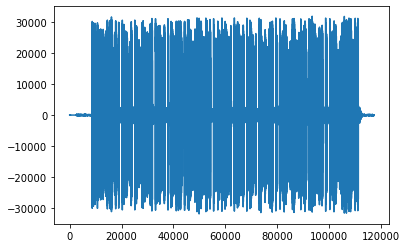

In [145]:
#testing sequence (recorded in audacity)
file = 'OOKtest'
samplerate, x = read(file+'.wav')
plt.plot(x)
IPython.display.Audio(file+'.wav')

In [146]:
#take out and change it back to a string
rxData = rx(x, sample, 2000)
print('\ntxData:')
print(txData)
print('\nrxData:')
print(rxData)

sigStart: 8789

txData:
[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 

# Decoding Longer Messages

In [147]:
#remove the sampling start bit
convertTx = rxData[1:]
print(str(len(convertTx)) + ' binary digits')
split = np.array_split(convertTx, len(convertTx)/8)

decodedMsg = ''
for item in split:
    s = [str(integer) for integer in item] #converts every 0 or 1 to '0' or '1'
    binString = "".join(s)                 #joins all the '0' or '1' together
    #print(binString)
    temp = chr(int(binString, 2))          #converts string of '0' and '1' to a character
    decodedMsg += temp                     #individual character is added to the decoded message being built
print(decodedMsg)

520 binary digits
Hello, my name is Alexander, this is an OOK prototyping project! 
